In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from pprint import pprint

from libs import run_model, calculate_doubling_time, plot_exponential_growth


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

Loaded libraries


In [2]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.mixture([[0.3, 212],
                            [0.1, 118],
                            [0.6, sq.lognorm(lognorm_mean=185.25, lognorm_sd=40)]])
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 115,
 5: 118,
 10: 118,
 20: 147,
 30: 165,
 40: 181,
 50: 199,
 60: 212,
 70: 212,
 80: 212,
 90: 222,
 95: 243,
 99: 285}

In [3]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.mixture([[0.1, 1 + sq.lognorm(0.005, 0.1, credibility=80)],
                           [0.8, 1],
                           [0.1, 1 - sq.lognorm(0.005, 0.1, credibility=80)]])
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.901,
 5: 0.978,
 10: 0.999,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.023,
 99: 1.1}

In [4]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: o3 at 1.75hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()

# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)

quarters = []
# Start with Q2 2025 since o3 launched in April
for year in range(2025, 2030):
    start_q = 2 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)
accel_samples = sq.sample(acceleration, n=n_samples)

print(f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}")
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_o3 = (quarter_date - O3_LAUNCH_DATE).days
    
    if days_from_o3 < 0:
        continue
    
    # Calculate task length for each sample
    # NO SHIFT for public models
    effective_days = days_from_o3  # Changed: removed + shift_samples
    
    # Use the calculate_doubling_time function logic
    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        if accel_samples[i] == 1:
            # Simple exponential
            doublings = effective_days / tau_samples[i]
            task_lengths[i] = 1.75 * (2 ** doublings)
        else:
            # Superexponential - use binary search
            low, high = 0, 100
            target_days = effective_days
            tau0 = tau_samples[i]
            a = accel_samples[i]
            
            for _ in range(50):
                mid = (low + high) / 2
                predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
                
                if predicted_days < target_days:
                    low = mid
                else:
                    high = mid
            
            doublings = (low + high) / 2
            task_lengths[i] = 1.75 * (2 ** doublings)
    
    # Cap at reasonable maximum
    task_lengths = np.minimum(task_lengths, 2000)
    
    # Calculate statistics
    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)
    
    def fmt_time(hrs):
        # Using work time: 8hr/day, 40hr/week
        if hrs < 1:
            return f"{int(hrs * 60)}min"
        elif hrs < 8:
            return f"{hrs:.1f}hr"
        elif hrs < 40:
            return f"{hrs/8:.1f}d"
        else:
            return f"{hrs/40:.1f}wk"
    
    ci_str = f"[{fmt_time(p5)} - {fmt_time(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")
    
    print(f"{year}Q{q:<7} {date_str:<12} {fmt_time(mean_val):<10} {fmt_time(median_val):<10} {ci_str:<25} {days_from_o3:>4}")
    
    results.append({
        'quarter': f"{year}Q{q}",
        'date': quarter_date,
        'mean': mean_val,
        'median': median_val,
        'p5': p5,
        'p95': p95,
        'days': days_from_o3,
        'task_lengths': task_lengths
    })
    
    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [(2, "2 hours"), (4, "4 hours"), (8, "1 day"), 
              (16, "2 days"), (24, "3 days"), (40, "1 week"), (174, "1 month")]

for hours, name in milestones:
    for r in results:
        if r['median'] >= hours:
            prob = np.mean(r['task_lengths'] >= hours) * 100
            date_str = r['date'].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: o3 at 1.75hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q2       2025-06-30   2.4hr      2.3hr      [2.2hr - 2.7hr]             75
2025Q3       2025-09-30   3.5hr      3.1hr      [2.8hr - 4.7hr]            167
2025Q4       2025-12-31   5.3hr      4.3hr      [3.7hr - 1.0d]             259

2026Q1       2026-03-31   1.0d       5.9hr      [4.7hr - 1.7d]             349
2026Q2       2026-06-30   1.6d       1.0d       [6.1hr - 2.9d]             440
2026Q3       2026-09-30   2.4d       1.4d       [7.9hr - 5.0d]             532
2026Q4       2026-12-31   3.7d       2.0d       [1.3d - 1.7wk]             624

2027Q1       2027-03-31   1.1wk      2.7d       [1.6d - 2.9wk]             714
2027Q2       2027-06-30   1.7wk      3.7d       [2.1d - 5.0wk]             805
2027Q3       2027-09-30 

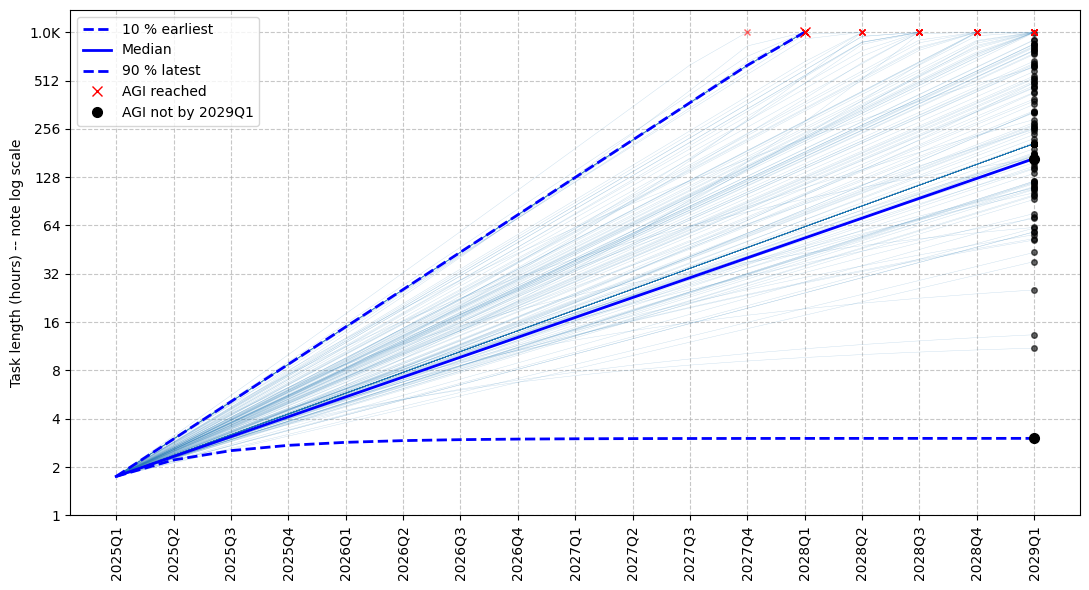

In [5]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    acceleration=acceleration,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [6]:
# Sanity check WITH SHIFT=0 for public models
print("\n" + "=" * 70)
print("Sanity Check - Current State")
print("=" * 70)
today = datetime(2025, 7, 1)
days_since_o3 = (today - O3_LAUNCH_DATE).days
print(f"Days since o3: {days_since_o3}")
print("Model predictions for PUBLIC models on July 1, 2025:\n")
# Calculate for today WITH NO SHIFT
task_lengths_today_public = np.zeros(n_samples)
for i in range(n_samples):
    if accel_samples[i] == 1:
        doublings = days_since_o3 / tau_samples[i]
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)
    else:
        # Binary search for doublings
        low, high = 0, 100
        target_days = days_since_o3  # NO SHIFT
        tau0 = tau_samples[i]
        a = accel_samples[i]
        
        for _ in range(50):
            mid = (low + high) / 2
            predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
            if predicted_days < target_days:
                low = mid
            else:
                high = mid
        
        doublings = (low + high) / 2
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)
task_lengths_today_public = np.minimum(task_lengths_today_public, 2000)

# Format the outputs using work time
p5_val = np.percentile(task_lengths_today_public, 5)
median_val = np.median(task_lengths_today_public)
mean_val = np.mean(task_lengths_today_public)
p95_val = np.percentile(task_lengths_today_public, 95)

print(f"5th percentile:  {fmt_time(p5_val)}")
print(f"Median:          {fmt_time(median_val)}")
print(f"Mean:            {fmt_time(mean_val)}")
print(f"95th percentile: {fmt_time(p95_val)}")
print("\nActual observed: Claude 4 at ~1.1-1.3 hours")
print(f"\nGap: {fmt_time(median_val)} predicted vs ~1.2hr actual")


Sanity Check - Current State
Days since o3: 76
Model predictions for PUBLIC models on July 1, 2025:

5th percentile:  2.2hr
Median:          2.3hr
Mean:            2.4hr
95th percentile: 2.7hr

Actual observed: Claude 4 at ~1.1-1.3 hours

Gap: 2.3hr predicted vs ~1.2hr actual
